In [1]:
from keras.applications import VGG16
import tensorflow as tf
import keras
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,KFold
from keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve

%matplotlib inline

Using TensorFlow backend.


In [2]:
## Define path ##
PATH = os.getcwd()
data_path = PATH + '/CT'
data_dir_list = os.listdir(data_path)

IMG_WIDTH=224
IMG_HEIGHT=224

IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
num_channel=1
num_classes = 2
labels_name={'Covid':0,'non-Covid':1}

img_data_list=[]
labels_list = []

## Retrieval of images and labels
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    label = labels_name[dataset]
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(224,224))
        img_data_list.append(input_img_resize)
        labels_list.append(label)

Loaded the images of dataset-Covid

Loaded the images of dataset-non-Covid



In [3]:
## Image normalization
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print (img_data.shape)

(2280, 224, 224, 3)


In [4]:
# convert class labels to on-hot encoding
labels = np.array(labels_list)
print(np.unique(labels,return_counts=True))
Y = np_utils.to_categorical(labels, num_classes)

(array([0, 1]), array([1152, 1128], dtype=int64))


In [5]:
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=4)
X_train.shape

(2052, 224, 224, 3)

In [16]:
### VGG16 initialization ###
from keras.models import Model
# include top should be False to remove the softmax layer
pretrained_model = VGG16()
pretrained_model = Model(inputs=pretrained_model.inputs, outputs=pretrained_model.layers[-2].output)
pretrained_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [19]:
## Feature extraction on train and val set

vgg_features_train = pretrained_model.predict(X_train)
vgg_features_val = pretrained_model.predict(X_test)

vgg_features_train = vgg_features_train.reshape(vgg_features_train.shape[0], vgg_features_train.shape[1] ,1)
vgg_features_val = vgg_features_val.reshape(vgg_features_val.shape[0], vgg_features_val.shape[1] ,1)

vgg_features_train.shape

(2052, 4096, 1)

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

## Fully Connected Layer ##
model2 = Sequential()
model2.add(Flatten(input_shape=(4096,1)))
model2.add(Dense(100, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))

# compile the model
model2.compile(optimizer=keras.optimizers.adam(lr=0.00004, decay= 1e-5), metrics=['accuracy'], loss='binary_crossentropy')

model2.summary()

# train model using features generated from VGG16 model
hist = model2.fit(vgg_features_train, y_train, epochs=100, batch_size=128, validation_data=(vgg_features_val, y_test))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               409700    
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 410,302
Trainable params: 410,102
Non-trainable params: 200
_________________________________________________________________
Train on 2052 samples, validate on 228 samples
Epoch 1/100
2052/2052 [==============================] - 0s 179us

2052/2052 [==============================] - 0s 48us/step - loss: 0.2579 - accuracy: 0.8981 - val_loss: 0.3382 - val_accuracy: 0.8816
Epoch 50/100
2052/2052 [==============================] - 0s 48us/step - loss: 0.2511 - accuracy: 0.8894 - val_loss: 0.3213 - val_accuracy: 0.8640
Epoch 51/100
2052/2052 [==============================] - 0s 47us/step - loss: 0.2324 - accuracy: 0.9016 - val_loss: 0.3496 - val_accuracy: 0.8640
Epoch 52/100
2052/2052 [==============================] - 0s 47us/step - loss: 0.2520 - accuracy: 0.8904 - val_loss: 0.3889 - val_accuracy: 0.8465
Epoch 53/100
2052/2052 [==============================] - 0s 48us/step - loss: 0.2406 - accuracy: 0.9001 - val_loss: 0.3899 - val_accuracy: 0.8509
Epoch 54/100
2052/2052 [==============================] - 0s 49us/step - loss: 0.2389 - accuracy: 0.9001 - val_loss: 0.4295 - val_accuracy: 0.8333
Epoch 55/100
2052/2052 [==============================] - 0s 48us/step - loss: 0.2236 - accuracy: 0.9059 - val_loss: 0.4148 - val_a

In [33]:
## Saving training output to csv file

hist_df = pd.DataFrame(hist.history) 
hist_csv_file = 'history/test_VGG_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

history = pd.read_csv("history/test_VGG_history.csv")
val_loss = history['val_loss'].to_numpy()
val_acc = history['val_accuracy'].to_numpy()
loss = history['loss'].to_numpy()
acc = history['accuracy'].to_numpy()


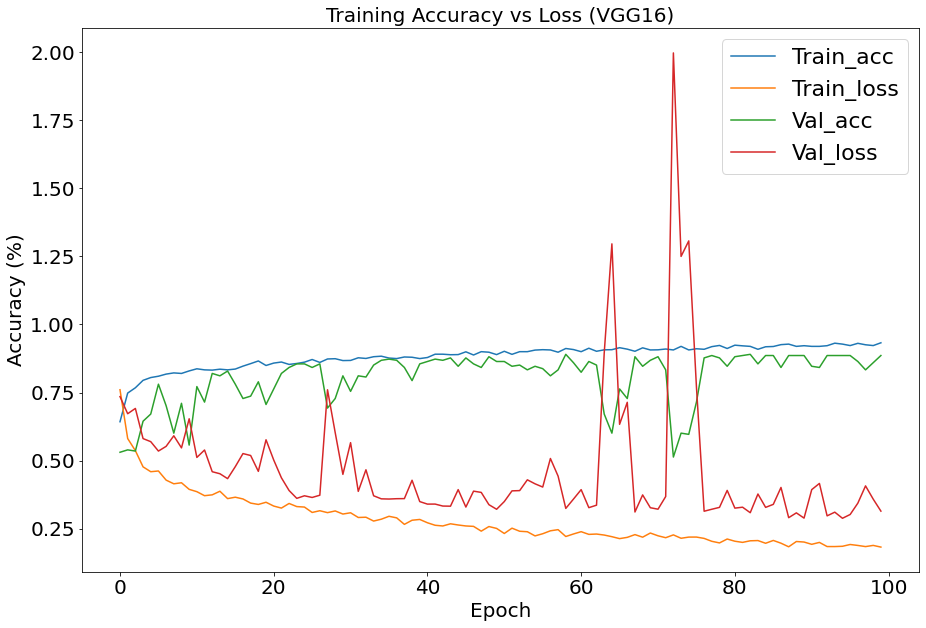

In [34]:
## Plot Acc vs Loss graph ##
plt.plot(acc)
plt.plot(loss)
plt.plot(val_acc)
plt.plot(val_loss)
plt.title('Training Accuracy vs Loss (VGG16)', fontsize=20,)
plt.yticks(fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend(['Train_acc', 'Train_loss', 'Val_acc', 'Val_loss'], loc='best', fontsize=22)
plt.gcf().set_size_inches(15,10) 
#plt.savefig('C:/Users/CooL/Desktop/Result/VGG/VGG_train_graph.jpg')
plt.show()

Optimal cut off point =  0.45519155
AUC =  0.9497
Optimal cut off point =  0.45519155
[[91  9]
 [13 87]] x = 0.45519 

91.00% 9.00% 13.00% 87.00%


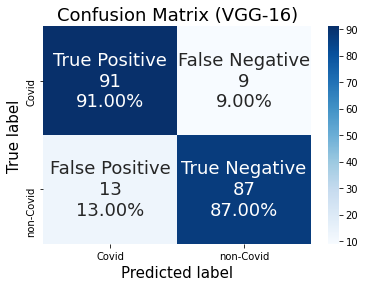

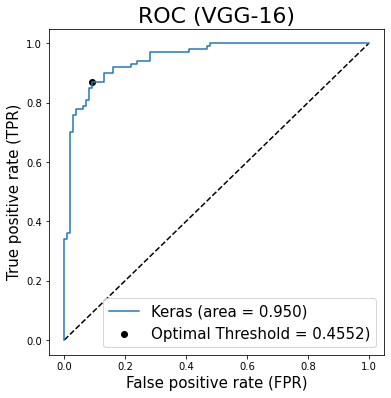

In [35]:
################ Testing phase VGG16 ################

PATH = os.getcwd()
data_path = PATH + '/Testing_Set'
data_dir_list = os.listdir(data_path)

import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix, roc_curve

test_list = []
y_pred = []
labels_name ={'Covid-19':0,'Non-Covid-19':1}


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    label = labels_name[dataset]
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(IMG_WIDTH,IMG_HEIGHT))
        test_list.append(input_img_resize)
        y_pred.append(label)

test_image = np.array(test_list)
test_image = test_image.astype('float32')
test_image /= 255

test_features = pretrained_model.predict(test_image)
test_features = test_features.reshape(200,4096,1)
predict_list = []
predict_1 = model2.predict_proba(test_features)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_pred, predict_1[:,1])

from sklearn.metrics import auc
import pandas as pd
auc_keras = auc(fpr_keras, tpr_keras)
optimum = thresholds_keras[np.argmax(tpr_keras - fpr_keras)]
print('Optimal cut off point = ',optimum)
print('AUC = ', auc_keras)

gmeans = np.sqrt(tpr_keras * (1-fpr_keras))
ix = np.argmax(gmeans)
optimal = thresholds_keras[ix]
print('Optimal cut off point = ',thresholds_keras[ix])

x = optimal # Best => x = 0.98892

for j in range(0,1):
    for i in range(0, len(predict_1)):
        if predict_1[i][1] >= x:
            predict_list.append(1)
        else:
            predict_list.append(0)
    print(confusion_matrix(y_pred, predict_list), 'x =',"%.5f" % x, '\n')

cf_matrix=confusion_matrix(y_pred, predict_list)
tp = cf_matrix[0][0]
fn = cf_matrix[0][1]
fp = cf_matrix[1][0]
tn = cf_matrix[1][1]

TrueP = '{0:.2%}'.format(tp/(tp+fn))
FalseN = '{0:.2%}'.format(fn/(tp+fn))
FalseP = '{0:.2%}'.format(fp/(fp+tn))
TrueN = '{0:.2%}'.format(tn/(fp+tn))
print(TrueP, FalseN, FalseP, TrueN)

xy_Labels = ['Covid', 'non-Covid']
group_names = ['True Positive', 'False Negative', 'False Positive','True Negative']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentage = [TrueP, FalseN, FalseP, TrueN]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentage)]
labels = np.asarray(labels).reshape(2,2)

### Confusion Matrix VGG16 ###
# plt.title('(VGG-16), Threshold = '+str("{:.4f}".format(optimal)), fontsize = 20)
plt.title('Confusion Matrix (VGG-16)',fontsize = 18)
sns.heatmap(cf_matrix, fmt='', annot=labels, annot_kws={'size':18} ,xticklabels=xy_Labels, yticklabels=xy_Labels, cmap='Blues')
plt.xlabel('Predicted label', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True label', fontsize = 15) # y-axis label with fontsize 15
#plt.savefig('C:/Users/CooL/Desktop/Result/VGG/VGG_CF.jpg')
plt.show()

### ROC Curves VGG16 ###
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.scatter(fpr_keras[ix],tpr_keras[ix], marker='o', color='black', label='Optimal Threshold = {:.4f})'.format(optimal))
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.title('ROC (VGG-16)',fontsize=22)
plt.legend(loc='best', fontsize=15)
#plt.savefig('C:/Users/CooL/Desktop/Result/VGG/VGG_graph.jpg')
plt.show()
